<a href="https://colab.research.google.com/github/sabrina-beck/masked-faces-deep-learning/blob/main/2020s2_mo434_projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Final

Universidade Estadual de Campinas (UNICAMP), Instituto de Computação (IC)

Profa. Sandra Avila, 2020s2

In [ ]:
print('173334: ' + 'Luiz Henrique Simioni Machado')
print('121192: ' + 'Mariane Previde')
print('157240: ' + 'Sabrina Beck Angelini')

173334: Luiz Henrique Simioni Machado
121192: Mariane Previde
157240: Sabrina Beck Angelini


In [ ]:
# Verificar qual GPU to usando
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Dec 13 21:49:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Verificar quanta memória
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Calcular o tempo total de execução
import time
start_time = time.time()

# Tema: Detecção de máscaras faciais
Com a pandemia do Covid-19 surgiu a necessidade das pessoas utilizarem máscaras para diminuir o contágio por Sars-CoV-2. A máscara vem cada vez mais se provando muito eficaz na diminuição do número de contágios ou da carga viral na transmissão, ajudando a diminuir casos de contaminação e internações de modo a evitar a sobrecarga dos hospitais e falecimentos. 

A ideia é desenvolver uma rede neural que consiga detectar em espaços públicos pessoas que estejam sem máscara ~~**ou usando a máscara incorretamente**~~. Com isso, agentes públicos poderiam abordar essas pessoas e fornecer uma máscara ~~**ou explicar o jeito correto de utilizá-la**~~.

**~~Nós pretendemos mesclar alguns datasets de modo a obter um conjunto maior para o treinamento~~. Nosso dataset final deverá ter ~~3~~ 2 classes:**
* Pessoas com máscaras
* Pessoas sem máscaras 
* ~~**Pessoas utilizando a máscara de forma errada**~~

In [ ]:
# Montar o Google Drive para salvar os modelos no final
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Base de Dados

A base de dados utilizada é a [Real World Masked Face Dataset](https://github.com/X-zhangyang/Real-World-Masked-Face-Dataset), optamos pela primeira opção de [download](https://github.com/X-zhangyang/Real-World-Masked-Face-Dataset) em que as amostras de imagens foram limpas e rotuladas contendo:


*   5000 faces com máscara de 525 pessoas
*   90000 faces sem máscara

Subimos uma cópia da base de dados feita no dia 23-11-2020 no Google Drive [aqui](https://drive.google.com/file/d/1UD8nf8CfuEycJwt2mBjfT9ElB2QoOMlx/view?usp=sharing).

In [ ]:
!pip install PyDrive &> /dev/null

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the zipped dataset based on its file ID on Drive.
file_id = '1UD8nf8CfuEycJwt2mBjfT9ElB2QoOMlx' #-- Updated File ID for my zip
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('RMFD.zip')
!unzip -q RMFD.zip

## Organização da Base de Dados

A base está organizada com os seguintes subdiretórios:
* `AFDB_face_dataset/`: imagens de pessoas sem máscara
* `AFDB_masked_face_dataset/`: imagens de pessoas com máscara

Cada subdiretório é composto por outros subdiretórios, cada um identificando as fotos de cada uma das 525 pessoas.

Devido à essa organização tivemos que fazer uma reorganização da base para deixar todas as imagens diretamente no subdiretório de sua classe, uma vez que estamos interessados somente na classificação `face` x `masked face`.

In [ ]:
from pathlib import Path

basePath = Path('self-built-masked-face-recognition-dataset')
maskPath = basePath/'AFDB_masked_face_dataset'
nonMaskPath = basePath/'AFDB_face_dataset'

In [ ]:
from pathlib import Path
from tqdm import tqdm
from os import listdir, rmdir, path
from shutil import move
import ntpath

def flattenClassDir(classDir, classDesc):
  classDirList = list(classDir.iterdir())
  count = 0
  for subDirectory in tqdm(classDirList, desc=classDesc):
    for imgPath in subDirectory.iterdir():
      count += 1
      filename = ntpath.basename(imgPath)
      move(imgPath, path.join(classDir, '%s.jpg' % count))
    rmdir(subDirectory)

flattenClassDir(nonMaskPath, 'non mask photos')
flattenClassDir(maskPath, 'mask photos')

mask photos: 100%|██████████| 525/525 [00:00<00:00, 4920.02it/s]


## A Base está Balanceada?

In [ ]:
mask_image_count = len(list(maskPath.glob('*.jpg')))
non_mask_image_count = len(list(nonMaskPath.glob('*.jpg')))
image_count = mask_image_count + non_mask_image_count

print('Masked photos: ', mask_image_count, ' (', '%.2f' % (mask_image_count / image_count * 100), '%)')
print('Non masked photos: ', non_mask_image_count, ' (', '%.2f' % (non_mask_image_count / image_count * 100), '%)')

Masked photos:  2203  ( 2.38 %)
Non masked photos:  90468  ( 97.62 %)


In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_non_mask = (1 / non_mask_image_count)*(image_count)/2.0 
weight_for_mask = (1 / mask_image_count)*(image_count)/2.0 

class_weights = {0: weight_for_non_mask , 1: weight_for_mask}

print('Weight for class 0 (non mask): {:.2f}'.format(weight_for_non_mask))
print('Weight for class 1 (mask): {:.2f}'.format(weight_for_mask))

Weight for class 0 (non mask): 0.51
Weight for class 1 (mask): 21.03


## Separando em treino e teste

In [ ]:


import os, shutil
import math

# Path to the directory where the original dataset was uncompressed
original_dataset_dir = basePath

# Directory where you’ll store your  dataset
base_dir = 'masked_vs_no_masked'

percent_to_train = 0.8;

try:
    os.stat(base_dir)
except:
    os.mkdir(base_dir)  

# Directory for the training splits
train_dir = os.path.join(base_dir, 'train')
try:
    os.stat(train_dir)
except:
    os.mkdir(train_dir)  

# Directory for the test splits
test_dir = os.path.join(base_dir, 'test')
try:
    os.stat(test_dir)
except:
    os.mkdir(test_dir)  

# Directory with training no masked pictures
train_no_masked_dir = os.path.join(train_dir, '0_no_masked')
try:
    os.stat(train_no_masked_dir)
except:
    os.mkdir(train_no_masked_dir)  

# Directory with training masked pictures
train_masked_dir = os.path.join(train_dir, '1_masked')
try:
    os.stat(train_masked_dir)
except:
    os.mkdir(train_masked_dir) 

# Directory with Test no maskedPictures
test_no_masked_dir = os.path.join(test_dir, '0_no_masked')
try:
    os.stat(test_no_masked_dir)
except:
    os.mkdir(test_no_masked_dir) 

# Directory with Test masked Pictures
test_masked_dir = os.path.join(test_dir, '1_masked')
try:
    os.stat(test_masked_dir)
except:
    os.mkdir(test_masked_dir) 

train_non_mask_image_count = math.ceil(non_mask_image_count*percent_to_train);

# Copies the first 80% non masked images to train_no_masked_dir. 
fnames = ['{}.jpg'.format(i) for i in range(1, train_non_mask_image_count+1)]
for fname in fnames:
    src = os.path.join(nonMaskPath, fname)
    dst = os.path.join(train_no_masked_dir, fname)
    shutil.copyfile(src, dst)

# Copies the next 20% no maskedimages to test_no_masked_dir
fnames = ['{}.jpg'.format(i) for i in range(train_non_mask_image_count + 2, non_mask_image_count+1)]
for fname in fnames:
    src = os.path.join(nonMaskPath, fname)
    dst = os.path.join(test_no_masked_dir, fname)
    shutil.copyfile(src, dst)

train_mask_image_count = math.ceil(mask_image_count*percent_to_train);
# Copies the first 80% masked images to train_masked_dir
fnames = ['{}.jpg'.format(i) for i in range(1, train_mask_image_count+1)]
for fname in fnames:
    src = os.path.join(maskPath, fname)
    dst = os.path.join(train_masked_dir, fname)
    shutil.copyfile(src, dst)

# Copies the next 20% masked images to test_masked_dir
fnames = ['{}.jpg'.format(i) for i in range(train_mask_image_count+2, mask_image_count+1)]
for fname in fnames:
    src = os.path.join(maskPath, fname)
    dst = os.path.join(test_masked_dir, fname)
    shutil.copyfile(src, dst)

# Sanity Check to ensure that Train and Test Folders have the expected number of images

print('Number of no masked Images in Training Directory is {}'.format(len(os.listdir(train_no_masked_dir))))
print('Number of masked Images in Training Directory is {}'.format(len(os.listdir(train_masked_dir))))
print('Number of no masked Images in Testing Directory is {}'.format(len(os.listdir(test_no_masked_dir))))
print('Number of masked Images in Testing Directory is {}'.format(len(os.listdir(test_masked_dir))))

Number of no masked Images in Training Directory is 72375
Number of masked Images in Training Directory is 1763
Number of no masked Images in Testing Directory is 18092
Number of masked Images in Testing Directory is 439


## Carregando a Base de dados

In [ ]:
batch_size = 64
img_width = 299
img_height = 299
input_shape = (img_width, img_height, 3)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_ds(preprocess_function):
  datagen = ImageDataGenerator(rescale=1./255,
            #  rotation_range=40,
            #  width_shift_range= 0.1,
            #  height_shift_range= 0.1,
            #  shear_range =  2,
            #  zoom_range =  0.2,
            horizontal_flip=  True,
            vertical_flip =  True,
            #  vertical_flip =  False,
            #  fill_mode = "nearest"
            validation_split=0.2,
            preprocessing_function=preprocess_function
            )

  train_ds = datagen.flow_from_directory(
            train_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode='binary',
            subset='training')
    
  val_ds = datagen.flow_from_directory(
            train_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode='binary',
            subset='validation')
  
  return (train_ds, val_ds)

In [ ]:
def load_test_ds(preprocess_function):
  datagen_test = ImageDataGenerator(
      rescale=1./255,
      preprocessing_function=preprocess_function
      )
  return datagen_test.flow_from_directory(
            test_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode='binary')


# Modelos

### Funções auxiliares

#### Cálculos de métricas

In [ ]:
from sklearn.metrics import confusion_matrix

def cm_calc(model, predict_result, ds_, p=0.5):
  np.set_printoptions(precision=3, suppress=True)

  # Matriz de confusão
  cm = confusion_matrix(ds_.classes, predict_result > p)
  print("Matriz de confusão")
  print(cm)

  return cm


In [ ]:

def balanced_acc_calc(cm): 
  # Matriz de confusão normalizada
  cmn = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
  balanced_acc = np.trace(cmn) / 2
  print("\n\nMatriz de confusão balanceada")
  print(cmn)
  print("\n\nAcurácia balanceada:", balanced_acc)
  return balanced_acc


#### Visualizações

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns
def plot_cm(cm,  p=0.5):
  #cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  # plt.title('Confusion matrix @{:.2f}')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non Mask Detected (True Negatives): ', cm[0][0])
  print('Non Mask Incorrectly Detected (False Positives): ', cm[0][1])
  print('With mask Missed (False Negatives): ', cm[1][0])
  print('With mask Detected (True Positives): ', cm[1][1])
  print('Total with Mask: ', np.sum(cm[1]))

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  #metrics = ['loss', 'auc', 'precision', 'recall']
  #metrics = ['loss', 'weighted_auc', 'weighted_precision', 'weighted_recall']
  interested_metrics = ['loss', 'weighted_auc', 'weighted_precision', 'weighted_recall']
  raw_metrics = list(history.history.keys())
  
  metrics = filter(lambda e: any(ext in e for ext in interested_metrics), raw_metrics)
  metrics = filter(lambda e: "val" not in e, metrics)
  metrics = list(metrics)

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'weighted_auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [ ]:
import sklearn
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch, history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.legend()

In [ ]:
def print_score(desc, score):
  print(desc, " metrics:")
  print('loss:', score[0])
  print('tp:', score[1])
  print('fp:', score[2])
  print('tn:', score[3])
  print('fn:', score[4])
  print('accuracy:', score[5])
  print('precision:', score[6])
  print('recall:', score[7])
  print('auc:', score[8])

#### Definições para os modelos

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [ ]:
epochs=100
optimizer=keras.optimizers.Adam(1e-3)
callbacks=[tf.keras.callbacks.EarlyStopping(
    
    monitor='val_loss', patience=10
    restore_best_weights=True #TODO: é melhor?
    )]

#TODO: ver se é melhor com essas configs
# callbacks=[tf.keras.callbacks.EarlyStopping(
#     monitor='val_auc', 
#     verbose=1,
#     patience=10,
#     mode='max',
#     restore_best_weights=True)
# ]

In [ ]:
import tempfile
import os
# TODO: ver se vale a pena
# initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')

## Baseline Resnet 50

In [ ]:
from tensorflow.keras.applications import resnet50

In [ ]:
(resnet50_train_ds, resnet50_val_ds) = load_ds(resnet50.preprocess_input)
resnet50_test_ds = load_test_ds(resnet50.preprocess_input)

Found 59311 images belonging to 2 classes.
Found 14827 images belonging to 2 classes.
Found 18531 images belonging to 2 classes.


In [ ]:
class_names = list(resnet50_train_ds.class_indices.keys())
class_names

['0_no_masked', '1_masked']

In [ ]:
# Modelo pré-treinado SEM as camadas densas (include_top = False)
resnet50_model = tf.keras.applications.ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape,
    )

# Congela camadas pré-treinadas
resnet50_model.trainable = False

resnet50_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
#bias_initializer= tf.keras.initializers.Constant(np.log([mask_image_count/non_mask_image_count])) 

# Inserindo novas camadas de saída com o número de classes adequadas para este problema
resnet50_full_model = tf.keras.Sequential([
  resnet50_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('') and 1 for the other ('')

  # tf.keras.layers.Dropout(0.3),  #TODO: checar se melhora
  # tf.keras.layers.Flatten(), #TODO: checar se melhora
  # tf.keras.layers.Dropout(0.5), #TODO: checar se melhora

  # tf.keras.layers.Dropout(0.2),  #TODO: checar se melhora

  tf.keras.layers.Dense(1, 
                        activation='sigmoid',
                        #bias_initializer= bias_initializer #TODO: checar se melhora
                        )
])

#ignora inicializacao 
#model.layers[-1].bias.assign([0.0])

resnet50_full_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 10, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Since there are two classes, use a binary cross-entropy loss with from_logits=True since the model provides a linear output.
resnet50_full_model.compile(
    # loss='categorical_crossentropy', 
    # loss='binary_crossentropy',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=METRICS,
    weighted_metrics=METRICS,
    optimizer=optimizer
    )

In [ ]:
trainable_variables = len(resnet50_full_model.trainable_variables)
print("Trainable Variables: ", trainable_variables)

Trainable Variables:  2


In [ ]:
# Treina o modelo
history_restnet50 = resnet50_full_model.fit(resnet50_train_ds, 
      batch_size=batch_size,
      epochs=epochs, 
      validation_data=resnet50_val_ds,
      callbacks=callbacks,
      class_weight=class_weights
      )

Epoch 1/100
927/927 [==============================] - 191s 206ms/step - loss: 0.6936 - weighted_tp: 242.3620 - weighted_fp: 444.5796 - weighted_tn: 87110.1797 - weighted_fn: 30846.2168 - weighted_accuracy: 0.7363 - weighted_precision: 0.3528 - weighted_recall: 0.0078 - weighted_auc: 0.5104 - val_loss: 0.6947 - val_weighted_tp: 0.0000e+00 - val_weighted_fp: 0.0000e+00 - val_weighted_tn: 28950.0000 - val_weighted_fn: 704.0000 - val_weighted_accuracy: 0.9763 - val_weighted_precision: 0.0000e+00 - val_weighted_recall: 0.0000e+00 - val_weighted_auc: 0.5000
Epoch 2/100
927/927 [==============================] - 178s 192ms/step - loss: 0.6930 - weighted_tp: 264.3949 - weighted_fp: 461.2136 - weighted_tn: 87093.5938 - weighted_fn: 30824.1660 - weighted_accuracy: 0.7363 - weighted_precision: 0.3644 - weighted_recall: 0.0085 - weighted_auc: 0.5249 - val_loss: 0.6934 - val_weighted_tp: 0.0000e+00 - val_weighted_fp: 0.0000e+00 - val_weighted_tn: 28950.0000 - val_weighted_fn: 704.0000 - val_weight

In [ ]:
# TODO: ver se vale a pena
# resnet50_full_model.save_weights(initial_weights)

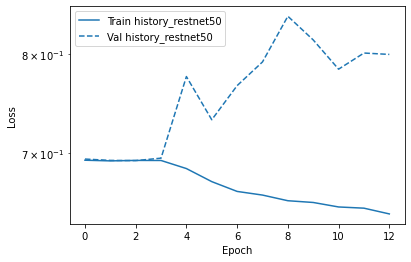

In [ ]:
plot_loss(history_restnet50, "history_restnet50", 0)

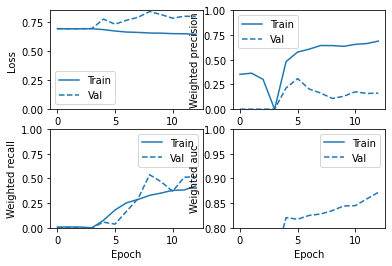

In [ ]:
plot_metrics(history_restnet50)

In [ ]:
val_predictions_baseline = resnet50_full_model.predict(resnet50_val_ds, batch_size=batch_size)
train_predictions_baseline = resnet50_full_model.predict(resnet50_train_ds, batch_size=batch_size) 

Matriz de confusão
[[13367  1108]
 [  323    29]]


Matriz de confusão balanceada
[[0.923 0.077]
 [0.918 0.082]]


Acurácia balanceada: 0.5029202975349348
Non Mask Detected (True Negatives):  13367
Non Mask Incorrectly Detected (False Positives):  1108
With mask Missed (False Negatives):  323
With mask Detected (True Positives):  29
Total with Mask:  352


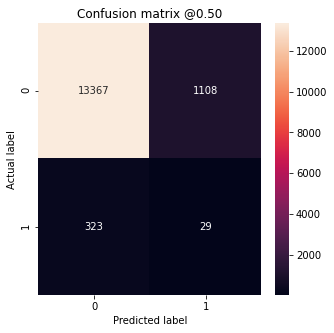

In [ ]:
cm = cm_calc(resnet50_full_model, val_predictions_baseline, resnet50_val_ds);
balanced_acc = balanced_acc_calc(cm)
plot_cm(cm)

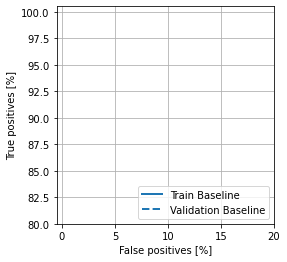

In [ ]:
plot_roc("Train Baseline", resnet50_train_ds.classes, train_predictions_baseline, color=colors[0])
plot_roc("Validation Baseline", resnet50_val_ds.classes, val_predictions_baseline, color=colors[0], linestyle='--')

plt.legend(loc='lower right')

In [ ]:
# Avalia o modelo na validação
score_full_restnet50 = resnet50_full_model.evaluate(
    resnet50_val_ds,
    verbose=1, 
    batch_size=batch_size
    )

print_score('Validation', score_full_restnet50)

232/232 [==============================] - 35s 150ms/step - loss: 0.8002 - weighted_tp: 360.0000 - weighted_fp: 1978.0000 - weighted_tn: 26972.0000 - weighted_fn: 344.0000 - weighted_accuracy: 0.9217 - weighted_precision: 0.1540 - weighted_recall: 0.5114 - weighted_auc: 0.8634
Validation  metrics:
loss: 0.8002225756645203
tp: 360.0
fp: 1978.0
tn: 26972.0
fn: 344.0
accuracy: 0.9216969013214111
precision: 0.15397775173187256
recall: 0.5113636255264282
auc: 0.8633577227592468


### Fine tuning

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet50_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet50_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# Since there are two classes, use a binary cross-entropy loss with from_logits=True since the model provides a linear output.
resnet50_full_model.compile(
    #loss='categorical_crossentropy', 
    #loss='binary_crossentropy',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=METRICS,
    weighted_metrics=METRICS,
    optimizer=optimizer
    )
    
resnet50_full_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 10, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
trainable_variables = len(resnet50_full_model.trainable_variables)
print("Trainable Variables: ", trainable_variables)

Trainable Variables:  214


In [ ]:
# TODO: ver se vale a pena
#resnet50_full_model.load_weights(initial_weights)

In [ ]:
resnet50_unfreeze_history = resnet50_full_model.fit(
    resnet50_train_ds, 
    batch_size=batch_size,
    epochs=epochs, 
    validation_data=resnet50_val_ds,
    callbacks=callbacks)

Epoch 1/100
927/927 [==============================] - 386s 416ms/step - loss: 1.2895 - weighted_weighted_tp: 3182.0000 - weighted_weighted_fp: 117778.0000 - weighted_weighted_tn: 26972.0000 - weighted_weighted_fn: 344.0000 - weighted_weighted_accuracy: 0.2034 - weighted_weighted_precision: 0.0263 - weighted_weighted_recall: 0.9024 - weighted_weighted_auc: 0.5149 - val_loss: 1.2895 - val_weighted_weighted_tp: 704.0000 - val_weighted_weighted_fp: 28950.0000 - val_weighted_weighted_tn: 0.0000e+00 - val_weighted_weighted_fn: 0.0000e+00 - val_weighted_weighted_accuracy: 0.0237 - val_weighted_weighted_precision: 0.0237 - val_weighted_weighted_recall: 1.0000 - val_weighted_weighted_auc: 0.5000
Epoch 2/100
927/927 [==============================] - 382s 412ms/step - loss: 1.2895 - weighted_weighted_tp: 2822.0000 - weighted_weighted_fp: 115800.0000 - weighted_weighted_tn: 0.0000e+00 - weighted_weighted_fn: 0.0000e+00 - weighted_weighted_accuracy: 0.0238 - weighted_weighted_precision: 0.0238 - 

In [ ]:
resnet50_unfreeze_history.history

{'loss': [1.289455533027649,
  1.2894556522369385,
  1.2894556522369385,
  1.2894556522369385,
  1.289455533027649,
  1.2894556522369385,
  1.289455533027649,
  1.2894556522369385,
  1.2894556522369385,
  1.2894556522369385,
  1.2894556522369385],
 'val_loss': [1.2895221710205078,
  1.2895221710205078,
  1.2895221710205078,
  1.2895221710205078,
  1.2895221710205078,
  1.2895221710205078,
  1.2895221710205078,
  1.2895221710205078,
  1.2895221710205078,
  1.2895221710205078,
  1.2895221710205078],
 'val_weighted_weighted_accuracy': [0.02374047413468361,
  0.02374047413468361,
  0.02374047413468361,
  0.02374047413468361,
  0.02374047413468361,
  0.02374047413468361,
  0.02374047413468361,
  0.02374047413468361,
  0.02374047413468361,
  0.02374047413468361,
  0.02374047413468361],
 'val_weighted_weighted_auc': [0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5],
 'val_weighted_weighted_fn': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.

In [ ]:

val_predictions_baseline = resnet50_full_model.predict(resnet50_val_ds, batch_size=batch_size)
train_predictions_baseline = resnet50_full_model.predict(resnet50_train_ds, batch_size=batch_size) 

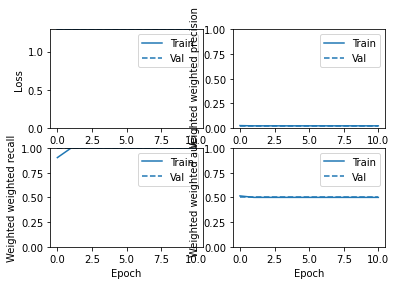

In [ ]:
plot_metrics(resnet50_unfreeze_history)

Matriz de confusão
[[    0 14475]
 [    0   352]]


Matriz de confusão balanceada
[[0. 1.]
 [0. 1.]]


Acurácia balanceada: 0.5
Non Mask Detected (True Negatives):  0
Non Mask Incorrectly Detected (False Positives):  14475
With mask Missed (False Negatives):  0
With mask Detected (True Positives):  352
Total with Mask:  352


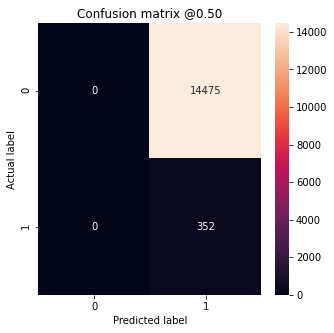

In [ ]:
cm = cm_calc(resnet50_full_model, val_predictions_baseline, resnet50_val_ds);
balanced_acc = balanced_acc_calc(cm)
plot_cm(cm)

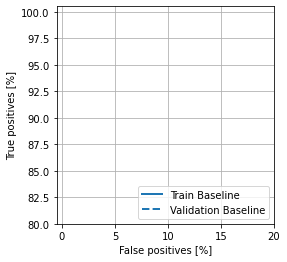

In [ ]:

plot_roc("Train Baseline", resnet50_train_ds.classes, train_predictions_baseline, color=colors[0])
plot_roc("Validation Baseline", resnet50_val_ds.classes, val_predictions_baseline, color=colors[0], linestyle='--')

plt.legend(loc='lower right')


In [ ]:
# Avalia modelo na validação
resnet50_unfreeze_score = resnet50_full_model.evaluate(resnet50_val_ds,verbose=1)

print_score('Validation', resnet50_unfreeze_score)

232/232 [==============================] - 35s 151ms/step - loss: 1.2895 - weighted_weighted_tp: 704.0000 - weighted_weighted_fp: 28950.0000 - weighted_weighted_tn: 0.0000e+00 - weighted_weighted_fn: 0.0000e+00 - weighted_weighted_accuracy: 0.0237 - weighted_weighted_precision: 0.0237 - weighted_weighted_recall: 1.0000 - weighted_weighted_auc: 0.5000
Validation  metrics:
loss: 1.2895221710205078
tp: 704.0
fp: 28950.0
tn: 0.0
fn: 0.0
accuracy: 0.02374047413468361
precision: 0.02374047413468361
recall: 1.0
auc: 0.5


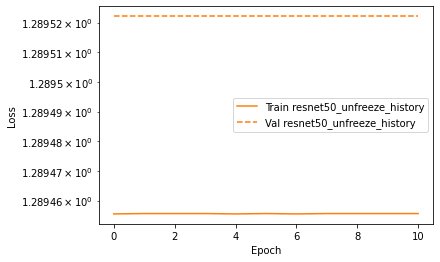

In [ ]:
plot_loss(resnet50_unfreeze_history, "resnet50_unfreeze_history", 1)

## Avaliação do modelo no test

In [ ]:
# cm = cm_calc(resnet50_full_model, resnet50_test_ds);
# balanced_acc = balanced_acc_calc(cm)
# plot_cm(cm)

In [ ]:
# Avalia modelo na validação
# resnet50_unfreeze_test_score = resnet50_full_model.evaluate(resnet50_test_ds,verbose=1)

# print_score('Test', resnet50_unfreeze_test_score)

# Tempo de execução

In [ ]:
execution_time = time.time() - start_time
print("--- %s seconds ---" % (execution_time))
print("--- %s minutes ---" % (execution_time / 60.0))
print("--- %s hours ---" % (execution_time / 3600.0))

--- 6983.026221036911 seconds ---
--- 116.38377035061518 minutes ---
--- 1.9397295058435864 hours ---


# Salvar o modelo treinado

In [ ]:
MODEL_FILE_SUFFIX = "_model.json"
MODEL_WEIGHTS_FILE_SUFFIX = "_model_weights.h5"
SAVE_DIR = "/content/drive/MyDrive/Unicamp/MO434 - Deep Learning/MO434 MC934 - Projeto Final"

In [ ]:
def save_model(model, model_name):
  
  base_filename = SAVE_DIR + "/" + model_name

  # serialize model to JSON
  model_filename = base_filename + MODEL_FILE_SUFFIX
  model_json = model.to_json()
  with open(model_filename, "w") as json_file:
      json_file.write(model_json)

  # serialize weights to HDF5
  weights_filename = base_filename + MODEL_WEIGHTS_FILE_SUFFIX
  model.save_weights(weights_filename)

In [ ]:
from keras.models import model_from_json

def load_trained_model(model_name):
  base_filename = SAVE_DIR + "/" + model_name

  # load json and create model
  model_filename = base_filename + MODEL_FILE_SUFFIX
  json_file = open(model_filename, 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)

  # load weights into new model
  weights_filename = base_filename + MODEL_WEIGHTS_FILE_SUFFIX
  loaded_model.load_weights(weights_filename)
  
  return loaded_model

In [ ]:
#save model
save_model(resnet50_full_model, "resnet50_tf")

# Carrega o modelo pra uso futuro

In [ ]:
# loaded_tf_model = load_trained_model("resnet50_tf")

In [ ]:
# loaded_tf_model.summary()